# Visualise column detection results

In [3]:
import pandas as pd
import os
import altair as alt
from IPython.display import display, HTML
alt.renderers.enable('notebook')
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

In [4]:
# We're going to combin all of the CSV files into one big dataframe

# Create an empty dataframe
combined_df = pd.DataFrame()

# Loop through the range of years
for year in range(1901, 1951):
    
    # Open the CSV file for that year as a dataframe
    year_df = pd.read_csv('{}.csv'.format(year))
    
    # Add the single year df to the combined df
    combined_df = combined_df.append(year_df)

To visualise the results, we first need to move the data around a bit to get it into a form we can chart using Altair.

Because this loops through dataframes for each volume calculating column widths, it is a bit slow...

In [5]:
# Replace any NaNs with 0
combined_df['column_positions'].fillna('0', inplace=True)

# Group images by volume using the 'referenceCode' column
vol_groups = combined_df.groupby('referenceCode')

# Create an empty dataframe
df_volumes = pd.DataFrame()

# Just used to limit the number of volumes processed for testing
max_rows = 200
row = 0

# Loop through the volume groups
for vol, pages in vol_groups:
    if row < max_rows:
        
        # Pages is a dataframe with details of all the pages in a volume
        pages = pages.copy()
        
        # Extract the page number from the file name and save as a new field
        pages['page_num'] = pages['name'].str.extract(r'_(\d+)\.').astype('int')
        
        # Sort pages by the page number
        pages = pages.sort_values(by='page_num')
        
        # Convert the width to a string, so we concatenate with the column positions
        pages['width'] = pages['width'].astype('str')
        
        # Add the page width to the end of the column positions string
        pages['column_positions'] = pages[['column_positions', 'width']].apply(lambda x: ','.join(x), axis=1)
        
        # pages['page_num'] = pages['col_pos'].astype('int')
        # display(pages['column_positions'].str.split(',', expand=True))
        
        # Create a new dataframe by exploding the column positions into separate rows, using the page number as the index
        new_df = pd.DataFrame(pages['column_positions'].str.split(',').tolist(), index=pages['page_num']).stack()
        
        # Change the page number from an index into a column
        new_df = new_df.reset_index([0, 'page_num'])
        
        # Rename the columns
        new_df.columns = ['page_num', 'col_pos']
        
        # Convert col_pos column to an integer
        new_df['col_pos'] = new_df['col_pos'].astype('int')
        
        # Number the columns in each row
        new_df['order'] = new_df.groupby('page_num').cumcount()
        
        # Add the volume name
        new_df['volume'] = vol
        
        # Add the volume number
        new_df['volume_num'] = int(vol[-3:])
        
        # In this loop we're going to calculate the width of each column by subtracting
        # the previous col_pos from the current one
        # Loop through the dataframe
        for i in range(1, len(new_df)):
            # if it's the first column then the width is equal to the position
            if new_df.loc[i, 'order'] == 0:
                new_df.loc[i, 'col_width'] = new_df.loc[i, 'col_pos']
                
            # Otherwise we have to get the previous value and subtract
            else:
                new_df.loc[i, 'col_width'] = new_df.loc[i, 'col_pos'] - new_df.loc[i-1, 'col_pos']
        
        # Append to the combined volumes dataframe
        df_volumes = df_volumes.append(new_df)
    row += 1

Let's have a peek inside the new dataframe.

In [6]:
df_volumes.head()

page_num  col_pos  order    volume  volume_num  col_width
0         1        0      0  N193-001           1        NaN
1         1     1811      1  N193-001           1     1811.0
2         1     3222      2  N193-001           1     1411.0
3         1     6237      3  N193-001           1     3015.0
4         2      205      0  N193-001           1      205.0

In [12]:
def chart_volumes(df, num_columns=25):
    chart = alt.Chart(df).mark_bar(size=3).encode(
    y=alt.X('page_num:O', axis=alt.Axis(labels=False, ticks=False), title='', scale=alt.Scale(rangeStep=3.4)),
    x=alt.Y('col_width:Q', axis=alt.Axis(labels=False, ticks=False), title=''),
    color=alt.Color('order:N', legend=None),
    tooltip=['volume', 'page_num', 'col_width'],
    order=alt.Order(
      # Sort the segments of the bars by this field
      'order',
      sort='ascending')
    ).properties(width=100).facet(
        facet='volume:N',
        columns=num_columns
    )
    return chart

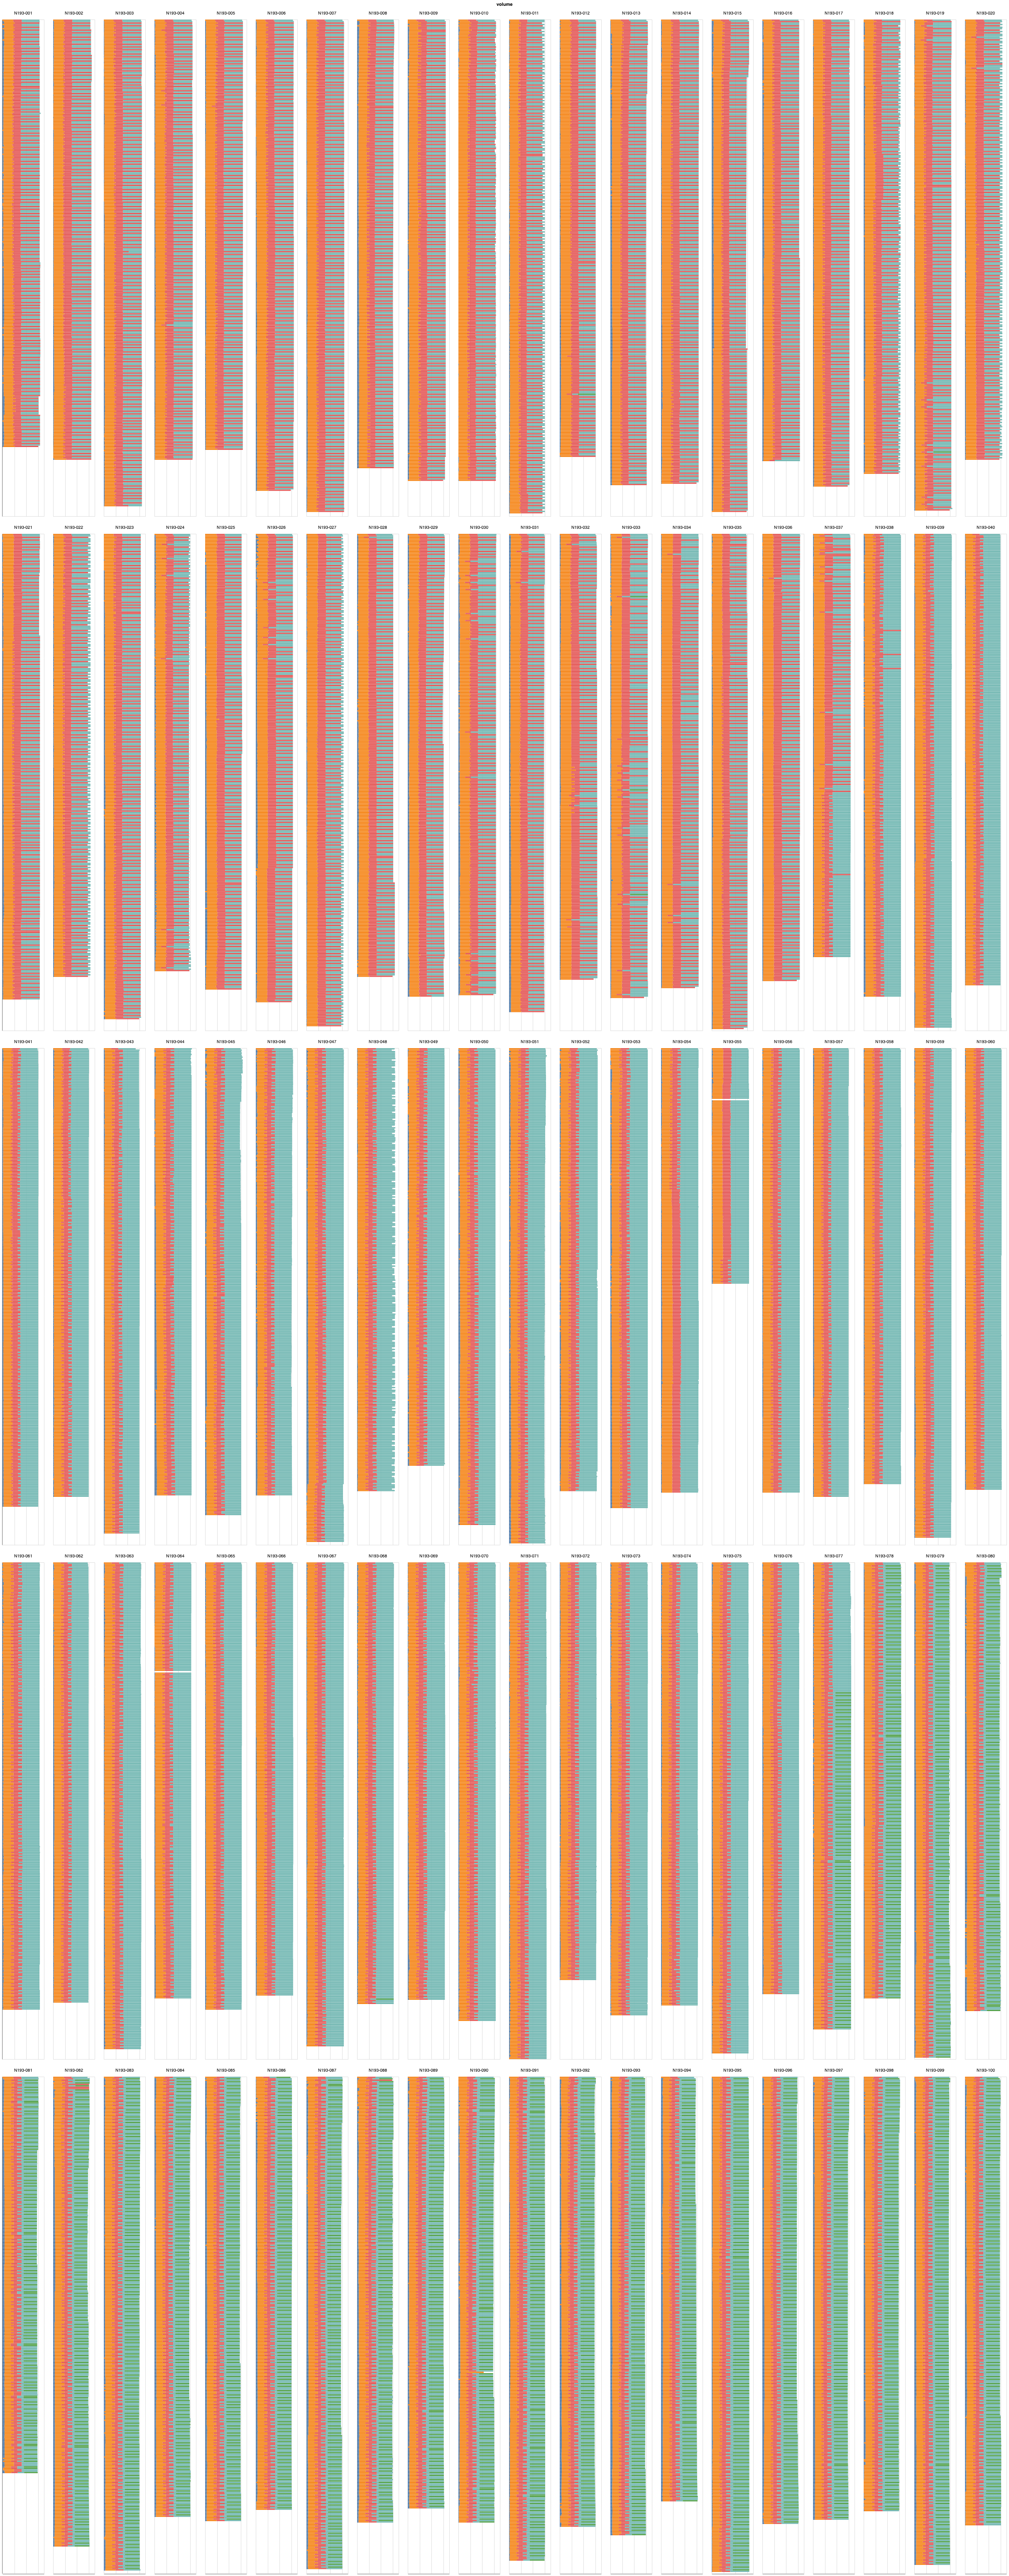

In [18]:
# Display the first 100 volumes
chart1 = chart_volumes(df_volumes.loc[df_volumes['volume_num'] <= 100], num_columns=20)
display(chart1)
chart1.save('docs/chart-vols-1-100.html')

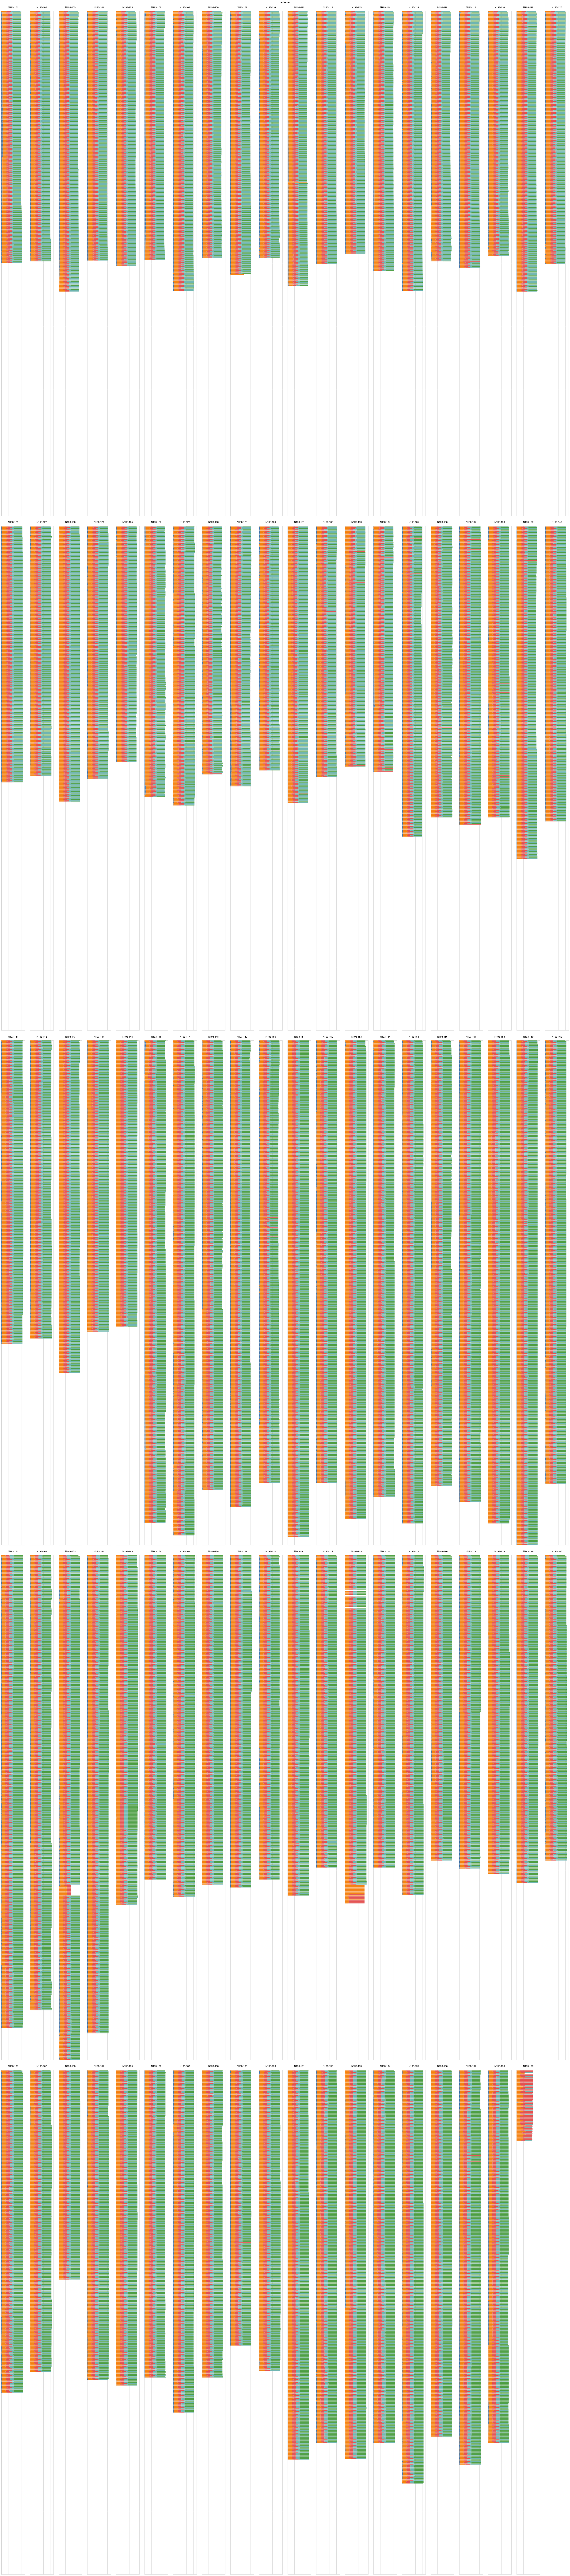

In [17]:
# Display the rest of the volumes
chart1 = chart_volumes(df_volumes.loc[df_volumes['volume_num'] > 100], num_columns=20)
display(chart1)
chart1.save('docs/chart-vols-100-198.html')